In [1]:
#Imports
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

## Data and dataloader preparation

In [2]:
data_path = untar_data(URLs.PETS)
print(data_path)

/home/jan/.fastai/data/oxford-iiit-pet


In [3]:
#Set the seed for reproducibility
np.random.seed(42)

In [4]:
#See the dataset structure
data_path.ls()[:3]

(#2) [Path('/home/jan/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/jan/.fastai/data/oxford-iiit-pet/images')]

Build `DataLoader` directly - highest level of FastAI API

In [5]:
filenames = get_image_files(data_path/ 'images')

In [6]:
L(data_path/'images')

(#1) [Path('/home/jan/.fastai/data/oxford-iiit-pet/images')]

In [7]:
#Get the filenames and build the pattern to extract class from them
filenames = get_image_files(data_path/ 'images')
regx_pattern = r'(.+)_\d+.jpg$'

#Define some Image and Batch level transformations
item_tfms = RandomResizedCrop(460, min_scale =0.8, ratio = (1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
batch_size = 32 

#Build databunch
dataloader1 = ImageDataLoaders.from_name_re(data_path, filenames, regx_pattern, batch_tfms=batch_tfms, item_tfms = item_tfms, bs = batch_size)

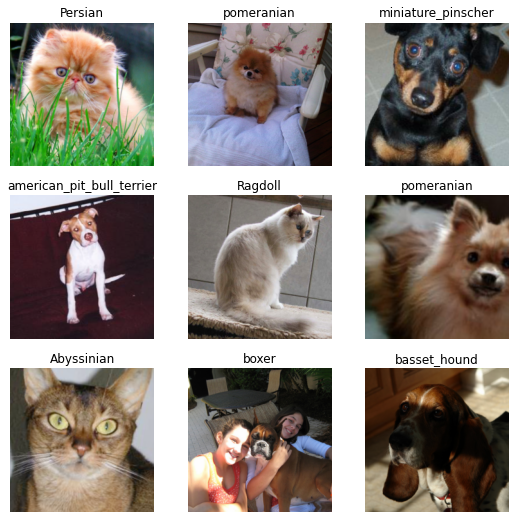

In [8]:
dataloader1.show_batch()

Alternatively, build `DataBlock` first (mid-level API) and then use it to generate `DataLoader`

In [9]:
# Define Datablock with (input,output) in blocks
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [10]:
image_path = data_path/'images'

In [11]:
#Build dataloaders
dataloaders2 = pets.dataloaders(image_path, bs=batch_size)

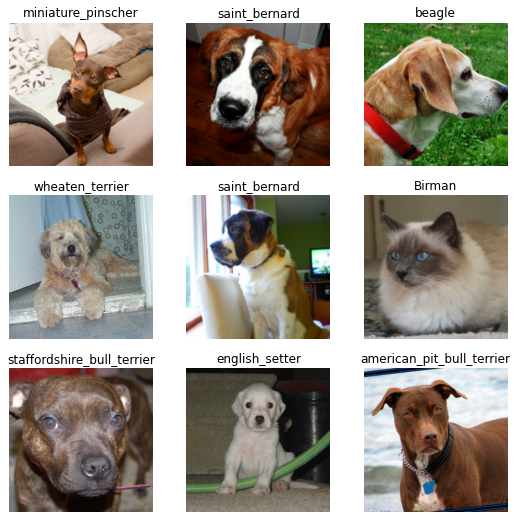

In [12]:
dataloaders2.show_batch()

One can also look at all the classes and their corresponding labels

In [13]:
dataloaders2.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Easiest classifier training

Create the simplest Learner (model+ training pipeline):
* pass the `Dataloaders`
* choose the model architecture
* choose the metrics to see how well model is performing
* choose loss function (so that model knows how to improve, default ` CrossEntropyFlat` in that case)
* choose optimizer (to tell the model how to adjust itself at each step, default `Adam` here)

In [14]:
learner = cnn_learner(dataloaders2, resnet50, pretrained=True, metrics=error_rate).to_fp16()

And train:

In [15]:
learner.fit_one_cycle(5)

In [16]:
learner.save('base_pet_classifier')

Path('models/base_pet_classifier.pth')

## Interpreting results

Using the interpration module and making sure we have all the validation scores/data aligned

In [17]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

len(dataloaders2.valid_ds)==len(losses)==len(idxs)

True

Plot where the model was most wrong

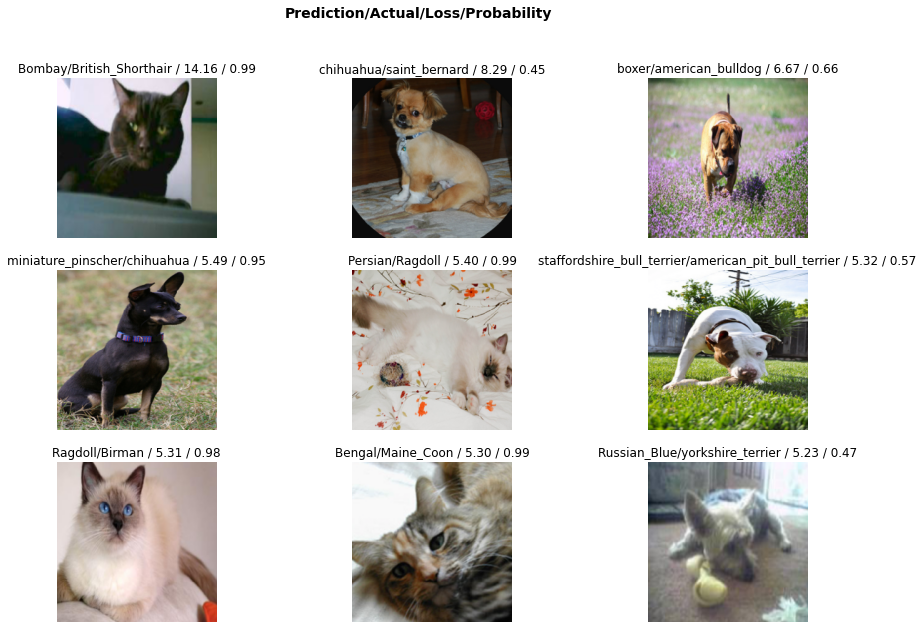

In [18]:
interp.plot_top_losses(9, figsize=(15,10))

Confusion Matrix will help too

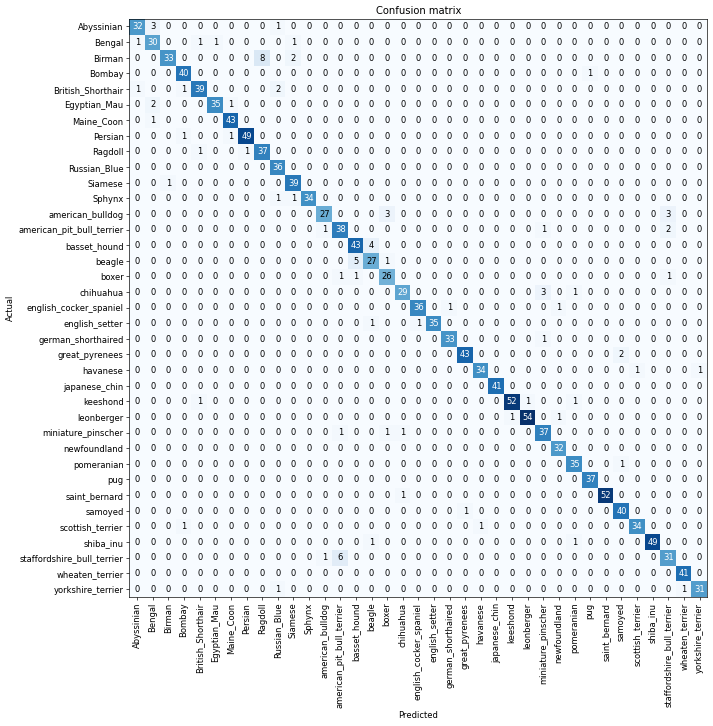

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Tuning the model a bit (prone to overfitting at the moment)

In [20]:
#Load the base model
learner.load('base_pet_classifier')

In [21]:
#Now the pretrained weights will change too, not only model head
learner.unfreeze()

In [22]:
learner.fit_one_cycle(4)

It seems that the Learning Rate is too high when all model layers are unlocked and the gradients fly all over the place - model performance drops

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.9054607491852948e-06)

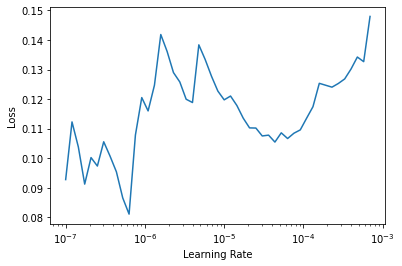

In [23]:
# Let's load it again, unfreeze and find a good learning rate
learner.load('base_pet_classifier')

learner.lr_find()

The LR between 1e-6 to 1e-4 seems good, we can actually set it as a slice so that deeper (earlier) layers in the model get adjusted less (they are already good at what they do)

In [24]:
learner.unfreeze()
learner.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

In [25]:
learner.save('tuned_pet_classifier')

Path('models/tuned_pet_classifier.pth')

Metrics have improved slightly, we can interpret it again. The easiest way to push the performance further would be to use larger model (ResNet50 for example).

In [26]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

len(dataloaders2.valid_ds)==len(losses)==len(idxs)

True

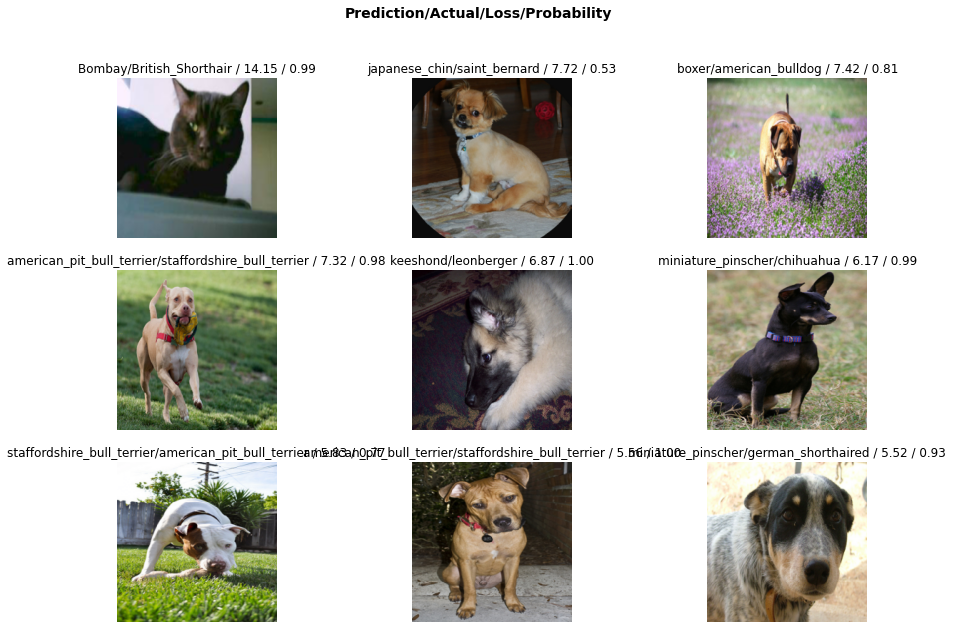

In [27]:
interp.plot_top_losses(9, figsize=(15,10))

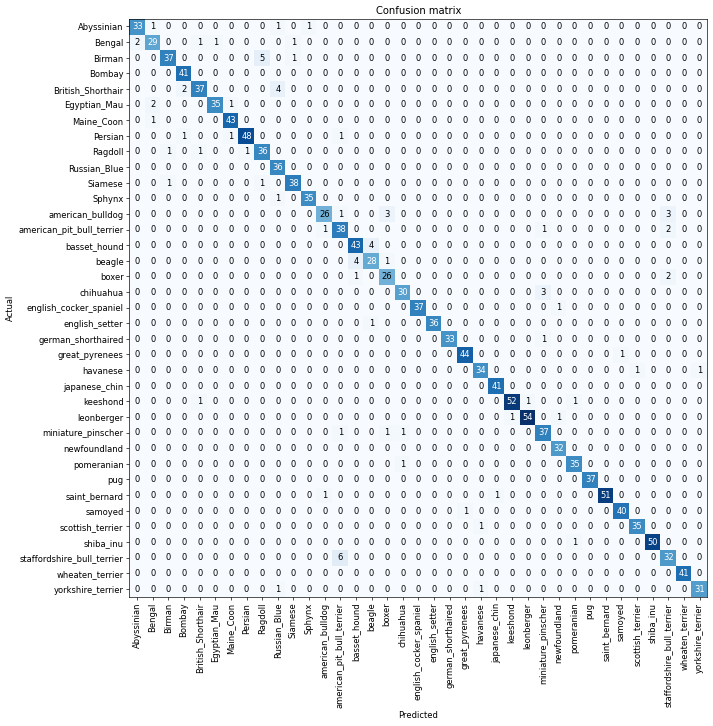

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Even the tuned model, still fails on the same images. Larger model might help, but cleaning/enlarging the dataset a bit would probably help too. It is also worth noting that despite overall decrease of error rate, in some specific cases error might be larger now 

# Different dataset - FOOD

Not all datasets are organized in the same way, but the `DataBlock` API is pretty elastic. Let's build a classifier for FOOD dataset, which contains images for 101 different dishes

In [29]:
data_path2 = untar_data(URLs.FOOD)
print(data_path2)

/home/jan/.fastai/data/food-101


Let's look how the dataset is organized:

In [30]:
L(get_files(data_path2, recurse=False))

(#6) [Path('/home/jan/.fastai/data/food-101/test.txt'),Path('/home/jan/.fastai/data/food-101/train.txt'),Path('/home/jan/.fastai/data/food-101/classes.txt'),Path('/home/jan/.fastai/data/food-101/test.json'),Path('/home/jan/.fastai/data/food-101/train.json'),Path('/home/jan/.fastai/data/food-101/labels.txt')]

In [31]:
L(get_files(data_path2/'images'))

(#101000) [Path('/home/jan/.fastai/data/food-101/images/lasagna/555862.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3874120.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3476066.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/2923855.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/2055421.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3717740.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/1675979.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3619303.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/1321748.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/2048823.jpg')...]

It seems that:
* Instead of all images being in images folder directly, they are in subfolders (according to class)
* Therefore, class names need to be taken from those folders, not the filenames
* There is already train/test split with list of files beloning to each fold in txt/json files

We can approach that in 2 ways:
1. Use the pre-defined train set as train+val and keep the test set separate for model evaluation (proper approach)
2. Use pre-defined train set as training set and pre-defined test as validation set (just for training purposes)

I'll build DataBlocks for both approaches

In [32]:
#Load the paths and add extensions
with open(str(data_path2/'train.txt'),'r') as f:
    train_paths = f.read().split('\n')[:-1]
    
with open(str(data_path2/'test.txt'),'r') as f:
    test_paths = f.read().split('\n')[:-1]
    
train_paths =[p+'.jpg' for p in train_paths]
test_paths =[p+'.jpg' for p in test_paths]

In [33]:
#Let's create a dictionary of nice labels for the classes too

with open(str(data_path2/'labels.txt'),'r') as f:
    labels = f.read().split('\n')[:-1]
with open(str(data_path2/'classes.txt'),'r') as f:
    classes = f.read().split('\n')[:-1]

labels_dict = {k:v for k,v in zip(classes,labels) }
print(len(classes), len(labels))

101 101


In [34]:
labels_dict

{'apple_pie': 'Apple pie',
 'baby_back_ribs': 'Baby back ribs',
 'baklava': 'Baklava',
 'beef_carpaccio': 'Beef carpaccio',
 'beef_tartare': 'Beef tartare',
 'beet_salad': 'Beet salad',
 'beignets': 'Beignets',
 'bibimbap': 'Bibimbap',
 'bread_pudding': 'Bread pudding',
 'breakfast_burrito': 'Breakfast burrito',
 'bruschetta': 'Bruschetta',
 'caesar_salad': 'Caesar salad',
 'cannoli': 'Cannoli',
 'caprese_salad': 'Caprese salad',
 'carrot_cake': 'Carrot cake',
 'ceviche': 'Ceviche',
 'cheesecake': 'Cheesecake',
 'cheese_plate': 'Cheese plate',
 'chicken_curry': 'Chicken curry',
 'chicken_quesadilla': 'Chicken quesadilla',
 'chicken_wings': 'Chicken wings',
 'chocolate_cake': 'Chocolate cake',
 'chocolate_mousse': 'Chocolate mousse',
 'churros': 'Churros',
 'clam_chowder': 'Clam chowder',
 'club_sandwich': 'Club sandwich',
 'crab_cakes': 'Crab cakes',
 'creme_brulee': 'Creme brulee',
 'croque_madame': 'Croque madame',
 'cup_cakes': 'Cup cakes',
 'deviled_eggs': 'Deviled eggs',
 'donuts'

In [35]:
len(train_paths),len(test_paths)

(75750, 25250)

In [36]:
from collections import Counter

In [37]:
train_labels = [f.split('/')[0] for f in train_paths]
Counter(train_labels)

Counter({'apple_pie': 750,
         'baby_back_ribs': 750,
         'baklava': 750,
         'beef_carpaccio': 750,
         'beef_tartare': 750,
         'beet_salad': 750,
         'beignets': 750,
         'bibimbap': 750,
         'bread_pudding': 750,
         'breakfast_burrito': 750,
         'bruschetta': 750,
         'caesar_salad': 750,
         'cannoli': 750,
         'caprese_salad': 750,
         'carrot_cake': 750,
         'ceviche': 750,
         'cheesecake': 750,
         'cheese_plate': 750,
         'chicken_curry': 750,
         'chicken_quesadilla': 750,
         'chicken_wings': 750,
         'chocolate_cake': 750,
         'chocolate_mousse': 750,
         'churros': 750,
         'clam_chowder': 750,
         'club_sandwich': 750,
         'crab_cakes': 750,
         'creme_brulee': 750,
         'croque_madame': 750,
         'cup_cakes': 750,
         'deviled_eggs': 750,
         'donuts': 750,
         'dumplings': 750,
         'edamame': 750,
         '

One can see that there are 101 classes, with 1000 images for each class split into 75% train and 25% test set.
Let's prepare the Datablocks

## 1. Using the pre-defined train for train+val

Here, `Randomsplitter()` is still needed to spit into train/val subsets. However `get_items` and `get_y` functions wil be different. Item/batch transformations can be left the same

In [38]:
def get_files1(path):
    with open(str(path/'train.txt'),'r') as f:
        train_paths = f.read().split('\n')[:-1]
    return L([path /'images'/ (p+'.jpg') for p in train_paths])

In [39]:
def get_label(f):
    return labels_dict[str(f).split('/')[-2]]

In [40]:
foods1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_files1,
                 splitter=RandomSplitter(valid_pct=0.25),
                 get_y=get_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [41]:
dataloaders3 = foods1.dataloaders(data_path2, bs=batch_size)

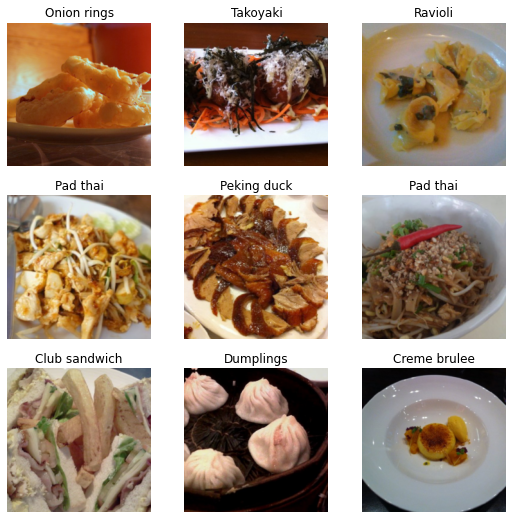

In [42]:
dataloaders3.show_batch()

## 2. Using pre-defined train for train, and pre-defined test for val

Now we can use same `get_image_files` as earlier (since we'll use all the images), we can reuse `get_label` from above as well. However, new splitter will be needed based on the information in the txts

In [43]:
with open(str(data_path2/'test.txt'),'r') as f:
    test_paths = f.read().split('\n')[:-1]
test_paths =  L([data_path2 /'images'/ (p+'.jpg') for p in test_paths])
 

In [44]:
def is_in_test(f):
    return f in test_paths

In [45]:
foods2 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=FuncSplitter(is_in_test),
                 get_y=get_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [46]:
#WARNING - SUPER SLOW
dataloaders4 = foods2.dataloaders(data_path2, bs=batch_size)

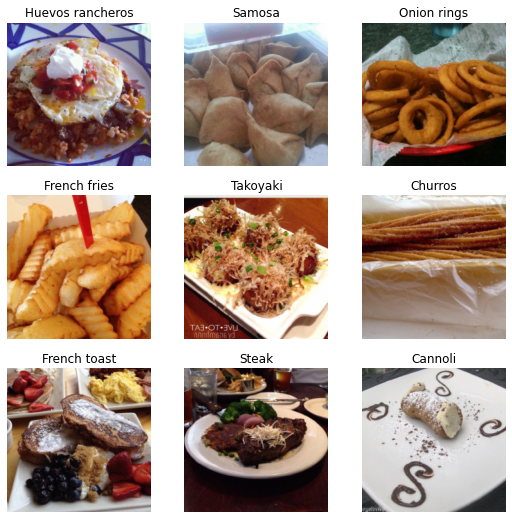

In [47]:
dataloaders4.show_batch()

That worked, but it was super slow, since every single item was checked against the test list. Let's see if it can be sped up using Pandas

In [48]:
#I already have test_paths, let's get train_paths now too
with open(str(data_path2/'train.txt'),'r') as f:
    train_paths = f.read().split('\n')[:-1]
train_paths =  L([data_path2 /'images'/ (p+'.jpg') for p in train_paths])

In [49]:
#Let's turn both these lists of paths into nice dictionaries
train_dicts = [{'fname':f, 'label': get_label(f), 'is_valid':False} for f in train_paths]
test_dicts = [{'fname':f, 'label': get_label(f), 'is_valid':True} for f in test_paths]

In [50]:
import pandas as pd

In [51]:
#Create DataFrame
df = pd.DataFrame.from_dict(train_dicts+test_dicts)
df.head(10)

fname      label  \
0  /home/jan/.fastai/data/food-101/images/apple_pie/1005649.jpg  Apple pie   
1  /home/jan/.fastai/data/food-101/images/apple_pie/1014775.jpg  Apple pie   
2  /home/jan/.fastai/data/food-101/images/apple_pie/1026328.jpg  Apple pie   
3  /home/jan/.fastai/data/food-101/images/apple_pie/1028787.jpg  Apple pie   
4  /home/jan/.fastai/data/food-101/images/apple_pie/1043283.jpg  Apple pie   
5  /home/jan/.fastai/data/food-101/images/apple_pie/1050519.jpg  Apple pie   
6  /home/jan/.fastai/data/food-101/images/apple_pie/1057749.jpg  Apple pie   
7  /home/jan/.fastai/data/food-101/images/apple_pie/1057810.jpg  Apple pie   
8  /home/jan/.fastai/data/food-101/images/apple_pie/1072416.jpg  Apple pie   
9  /home/jan/.fastai/data/food-101/images/apple_pie/1074856.jpg  Apple pie   

   is_valid  
0     False  
1     False  
2     False  
3     False  
4     False  
5     False  
6     False  
7     False  
8     False  
9     False

I need separate `get_x` and `get_y` functions now to get filenames and labels respectively for each row in the DataFrame. I also use the `ColSplitter` function to split into train/val based on the `is_valid` column 

In [52]:
foods3 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=ColReader('fname'),
                 splitter=ColSplitter('is_valid'),
                 get_y=ColReader('label'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [53]:
dataloaders5 = foods3.dataloaders(df, bs=batch_size)

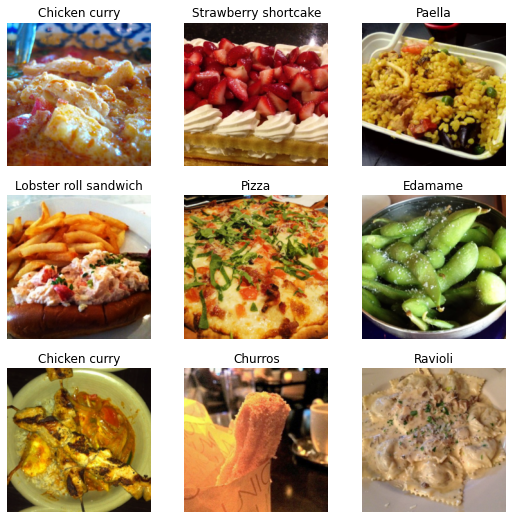

In [54]:
dataloaders5.show_batch()

This was much faster, yielding the same result. One can verify that dataloader3 is smaller (as expected), while 4 and 5 have the same size (split done properly)

In [55]:
len(dataloaders3.train),len(dataloaders4.train),len(dataloaders5.train)

(1775, 2367, 2367)

# Creating own dataset

Thankfully, creating a classification dataset is fairly easy. One just needs to fetch images with corresponding labels, withoout further tampering with the image needed. This is reverse of what image search engines are doing.
I'll use DuckDuckGo for image search, since it has easy to access API

In [56]:
'''
That's a concise function set to download images from DDG API, courtesy of Jorge Poblete 
(https://github.com/JorgePoblete/DuckDuckGoImages/blob/master/src/DuckDuckGoImages.py)
Most of the time, if there is an existing tool that does the job, there is no point in writing one yourself
'''

import re
import io
import os
import json
import uuid
import shutil
import random
import requests
from PIL import Image
from joblib import Parallel, delayed

def download(query, folder='.', max_urls=None, thumbnails=False, parallel=False, shuffle=False, remove_folder=False):
    if thumbnails:
        urls = get_image_thumbnails_urls(query)
    else:
        urls = get_image_urls(query)

    if shuffle:
        random.shuffle(urls)

    if max_urls is not None and len(urls) > max_urls:
        urls = urls[:max_urls]

    if remove_folder:
        _remove_folder(folder)

    _create_folder(folder)
    if parallel:
        return _parallel_download_urls(urls, folder)
    else:
        return _download_urls(urls, folder)

def _download(url, folder):
        try:
            filename = str(uuid.uuid4().hex)
            while os.path.exists("{}/{}.jpg".format(folder, filename)):
                filename = str(uuid.uuid4().hex)
            response = requests.get(url, stream=True, timeout=1.0, allow_redirects=True)
            with Image.open(io.BytesIO(response.content)) as im:
                with open("{}/{}.jpg".format(folder, filename), 'wb') as out_file:
                    im.save(out_file)
                    return True
        except:
            return False

def _download_urls(urls, folder):
    downloaded = 0
    for url in urls:
        if _download(url, folder):
            downloaded += 1
    return downloaded

def _parallel_download_urls(urls, folder):
    downloaded = 0
    with Parallel(n_jobs=os.cpu_count()) as parallel:
        results = parallel(delayed(_download)(url, folder) for url in urls)
        for result in results:
            if result:
                downloaded += 1
    return downloaded

def get_image_urls(query):
    token = _fetch_token(query)
    return _fetch_search_urls(query, token)

def get_image_thumbnails_urls(query):
    token = _fetch_token(query)
    return _fetch_search_urls(query, token, what="thumbnail")

def _fetch_token(query, URL="https://duckduckgo.com/"):
    res = requests.post(URL, data={'q': query})
    if res.status_code != 200:
        return ""
    match = re.search(r"vqd='([\d-]+)'", res.text, re.M|re.I)
    if match is None:
        return ""
    return match.group(1)

def _fetch_search_urls(query, token, URL="https://duckduckgo.com/", what="image"):
    query = {
        "vqd": token,
        "q": query,
        "l": "wt-wt",
        "o": "json",
        "f": ",,,",
        "p": "2"
    }
    urls = []

    res = requests.get(URL+"i.js", params=query)
    if res.status_code != 200:
        return urls

    data = json.loads(res.text)
    for result in data["results"]:
        urls.append(result[what])

    while "next" in data:
        res = requests.get(URL+data["next"], params=query)
        if res.status_code != 200:
            return urls
        data = json.loads(res.text)
        for result in data["results"]:
            urls.append(result[what])
    return urls

def _remove_folder(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder, ignore_errors=True)

def _create_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

Let's see if it works

In [57]:
download('serval cat', max_urls=10, folder='./cats')

8

In [58]:
get_image_files(Path('./cats'))

(#13) [Path('cats/19092c1bb6f74e1bb1a0c7d9ad737f33.jpg'),Path('cats/066aa8186dbf4c41b33b781d51f58f0a.jpg'),Path('cats/7a566701d94d4ea4b52b4b9512ade9f8.jpg'),Path('cats/0e0e93ac12d744dcbde82ebefba37f06.jpg'),Path('cats/398d37b8a87a422fae9af0cbc384bfdf.jpg'),Path('cats/ff57b0c1dd464d2aa5e58eb7074dad37.jpg'),Path('cats/21d863e2f09d486b8bd3ff2d6cf8403b.jpg'),Path('cats/6514ed365972425a9e8eed7b4ddaafd4.jpg'),Path('cats/7cb8b7424fb6402cbdd59574774c0b64.jpg'),Path('cats/6d25d31151314444bcfbd94a53e1842b.jpg')...]

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

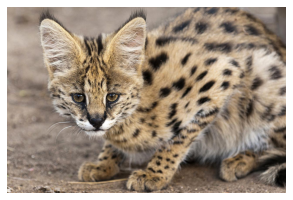

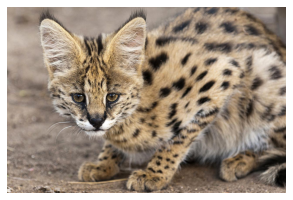

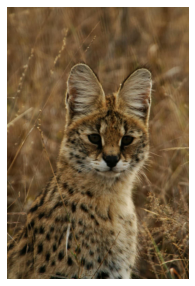

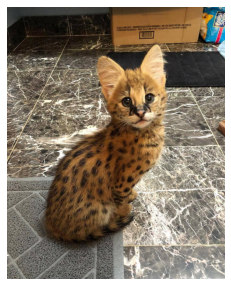

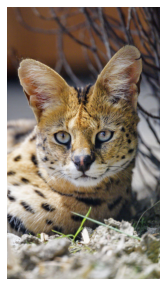

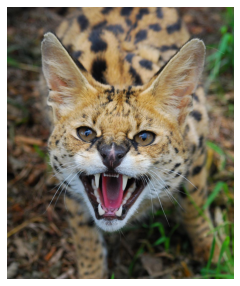

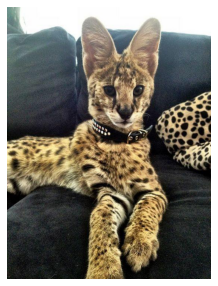

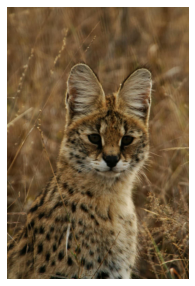

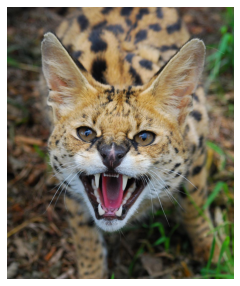

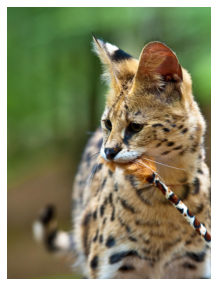

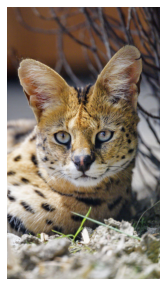

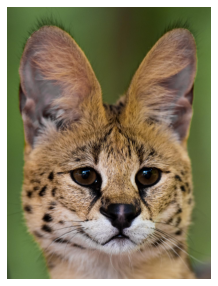

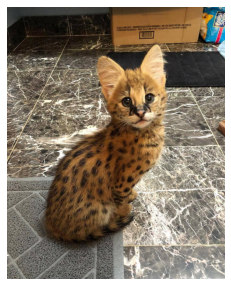

In [59]:
[show_image(Image.open(i)) for i in get_image_files(Path('./cats'))]

It seems that it works pretty well, let's use it to build function craeting dataset organised in the same way as FOOD dataset

In [60]:
class_dict = {'tiger': "Tiger", 'lion': 'Lion', 'mountain_lion': 'Mountain Lion'}

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
def ddg_dataset(class_dict, main_folder = './ddg_dataset', split = None, max_urls = 10, parallel = False):
    """
    class_dict: dictionary with raw_class_name:nice label key:value pairs
    main_folder: where the dataset will be downloaded
    split: if you want to have predefined train/test split, put a 0-1 float here
    max_urls: upper limit of images per class
    
    """
    train_images = []
    test_images=[]
    for k,v in class_dict.items():
        download(v, max_urls=max_urls, folder=f'{main_folder}/images/{k}', parallel=parallel)
        if split:
            images = get_image_files(Path(f'{main_folder}/images/{k}'))
            #sometimes downloaded images have errors, I need to filter them out
            error_images = verify_images(images)
            for ei in error_images:
                os.remove(ei)
            verified_images = L([i for i in images if i not in error_images])
            
            parsed_images = [f'{k}/{f.stem}' for f in verified_images]
            train, test = train_test_split(parsed_images, test_size = split)
            train_images += train
            test_images += test
            
    if split:
        with open(f'{main_folder}/test.txt','w') as f:
            f.write('\n'.join(test_images)+'\n')
        with open(f'{main_folder}/train.txt','w') as f:
            f.write('\n'.join(train_images)+'\n')
    
    with open(f'{main_folder}/classes.txt','w') as f:
        f.write('\n'.join(list(class_dict.keys()))+'\n')
    with open(f'{main_folder}/labels.txt','w') as f:
        f.write('\n'.join(list(class_dict.values()))+'\n')
    

In [63]:
ddg_dataset(class_dict, split = 0.2, parallel=True, main_folder='./wild_cats', max_urls=100)

In [64]:
wild = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_files1,
                 splitter=RandomSplitter(valid_pct=0.25),
                 get_y=get_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [65]:
labels_dict = class_dict

In [66]:

dataloaders6 = wild.dataloaders(Path('./wild_cats'), bs=32)

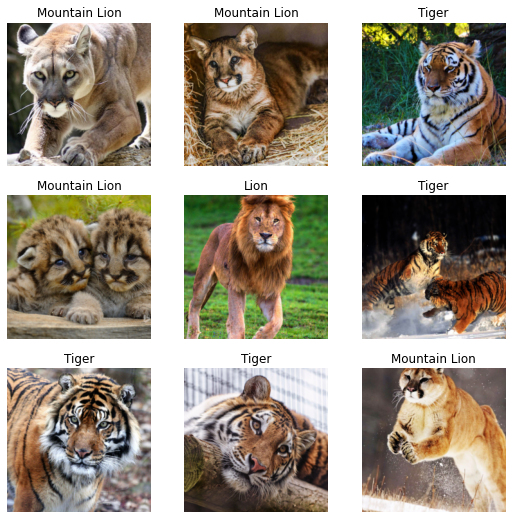

In [67]:
dataloaders6.show_batch()

In [68]:
learner = cnn_learner(dataloaders6, resnet50, pretrained=True, metrics=error_rate).to_fp16()

In [69]:
learner.fit_one_cycle(5)

In [70]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

len(dataloaders6.valid_ds)==len(losses)==len(idxs)

True

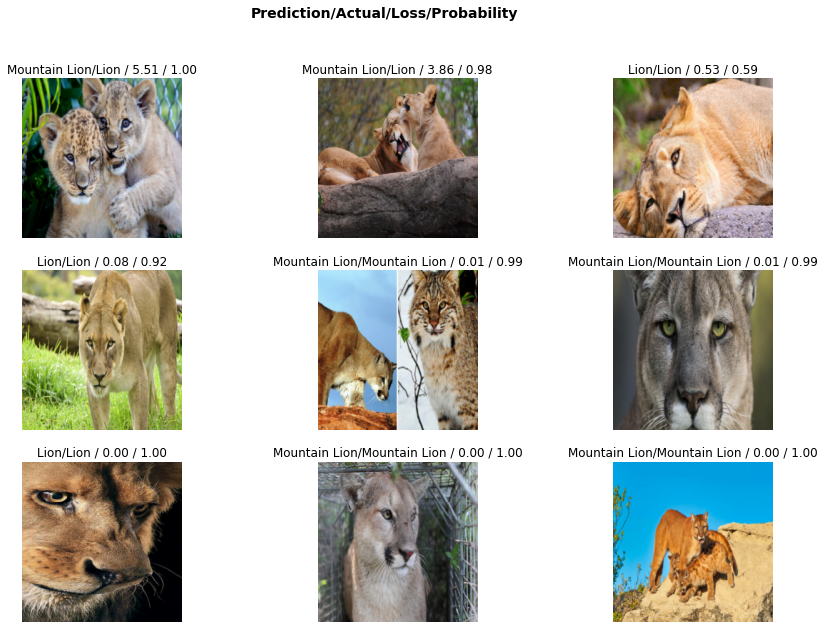

In [71]:
interp.plot_top_losses(9, figsize=(15,10))

One can see that the classifier works pretty well, expanding dataset to have more scenery and cub pictures would probably push it closer to 100% accuracy